In [1]:
import os
import types
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import log_softmax, nll_loss, softmax

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.visualization.toy_example import plot_moons, plot_multiclass, show_density_grid, show_acquisition_grid, plot_performance_curves
from src.data.toy_example import generate_moons, generate_multiclass
from src.methods.target_input_distribution import MultivariateGaussian

from src.models.utils import GP_sample
from src.methods.toy_example import run_active_learning_loop_toy

import autograd.numpy as np
from autograd import hessian
from autograd.misc import flatten


In [2]:
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal
from math import sqrt

class SimpleLLLA(nn.Module):
    def __init__(self, alpha=1., num_classes: int = 2, n_posterior_samples: int = 1000):
        super(SimpleLLLA, self).__init__()
        
        self.feature_extr = nn.Sequential(
            nn.Linear(2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(), 
            nn.Linear(32, 32), 
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )      
        self.classifier = nn.Linear(32, num_classes, bias=False)
        
        self.alpha                  = alpha
        self.n_posterior_samples    = n_posterior_samples
        self.num_classes            = num_classes
        self.LLLA_fitted            = False
        self.variance_factor = 1.

    def forward(self, x: torch.FloatTensor):
        x = self.feature_extr(x)
        return self.classifier(x)

    def predict_MAP_proba(self, x: np.ndarray):
        x       = torch.FloatTensor(x)
        outputs = self.forward(x)
        return softmax(outputs, dim=1).numpy()
    
    def predict_posterior_proba(self, x: np.ndarray, seed: int = 0):
        posterior_samples   = self.sample(X=x, n_samples=self.n_posterior_samples, seed=seed)
        probs = softmax(posterior_samples, dim=0).mean(axis=1).T  
        return probs
    
    def fit_LLLA(self, Xtrain: torch.FloatTensor, ytrain: torch.LongTensor):
        ### PARTS OF CODE DONE BY THESE PERSONS: https://github.com/wiseodd/last_layer_laplace/blob/master/bnn_laplace_multiclass.ipynb  
        self.LLLA_fitted = True

        self.W_last_layer = list(self.parameters())[-1]
        shape_W = self.W_last_layer.shape

        # Use BackPACK to get the Kronecker-factored last-layer covariance
        extend(self.classifier)
        loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

        loss = loss_func(self(Xtrain), ytrain)
        with backpack(extensions.KFAC()):
            loss.backward()

        # The Kronecker-factored Hessian of the negative log-posterior
        A, B = self.W_last_layer.kfac

        # The weight decay used for training is the Gaussian prior's precision
        prec0 = 5e-4

        # The posterior covariance's Kronecker factors
        self.U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
        self.V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))

    def sample(self, X: np.ndarray, n_samples: int = 1000, seed: int = 0):
        ### PARTS OF CODE DONE BY THESE PERSONS: https://github.com/wiseodd/last_layer_laplace/blob/master/bnn_laplace_multiclass.ipynb  
        assert self.LLLA_fitted, "You must explicitly fit the LLLA layer before trying to sample!" 
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # feed input through first part of network
        with torch.no_grad():
            z = self.feature_extr(torch.FloatTensor(X))
            # MAP prediction
            Wmap = z @ self.W_last_layer.T

            # v is the induced covariance. 
            # See Appendix B.1 of https://arxiv.org/abs/2002.10118 for the detail of the derivation.
            v = torch.diag(z @ self.V @ z.T).reshape(-1, 1, 1) * self.U 
            
            output_dist = MultivariateNormal(Wmap, v * self.variance_factor)
            posterior_samples     = torch.zeros((self.num_classes, n_samples, len(X)))
            for n in range(n_samples):
                posterior_samples[:, n, :] = output_dist.rsample().T 
                
        return posterior_samples

In [37]:
def train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

    accs    = {'train': {}, 'validation': {}}
    losses  = {'train': {}, 'validation': {}}
    current_best_loss = np.inf

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()

        # Set grad zero
        optimizer.zero_grad()

        # Get predictions
        outputs         = model(Xtrain)
        log_probs       = log_softmax(outputs, dim=1)

        # Compute loss
        loss    = nll_loss(log_probs, ytrain)
        loss.backward()
        # Optimize
        optimizer.step()

        # Compute accuracy for batch
        _, pred_class   = torch.topk(outputs, k=1)
        train_acc       = torch.mean((pred_class.flatten() == ytrain).float()).cpu()
        train_loss      = loss.item()

        # Store information
        accs['train'][epoch]    = train_acc 
        losses['train'][epoch]  = train_loss
        
        if epoch % val_step == 0:
            model.eval()
            with torch.no_grad():
                # Get predictions
                outputs         = model(Xtest)
                log_probs       = log_softmax(outputs, dim=1)
                
                # Compute loss
                loss    = nll_loss(log_probs, ytest)

                # Compute accuracy for batch
                _, pred_class   = torch.topk(outputs, k=1)
                val_acc         = torch.mean((pred_class.flatten() == ytest).float()).cpu()
                val_loss        = loss.item()

                accs['validation'][epoch]   = val_acc 
                losses['validation'][epoch] = val_loss

            if losses['validation'][epoch] < current_best_loss:
                current_best_loss   = losses['validation'][epoch]
                best_model          = model
                best_epoch          = epoch 
                
                torch.save(model.state_dict(), f'../models/MNIST/{model.__class__.__name__}_best.pth')
                # print("Saved new model!")

        pbar.set_description(f"EPOCH {epoch+1}/{epochs}: Train acc. = {accs['train'][epoch]:.4f} \t | Validation acc. = {accs['validation'][epoch]:.4f} \t | Train loss = {losses['train'][epoch]:.4f} \t | Validation loss = {losses['validation'][epoch]:.4f}")
    
    print(f"BEST EPOCH = {best_epoch}")
    return best_model

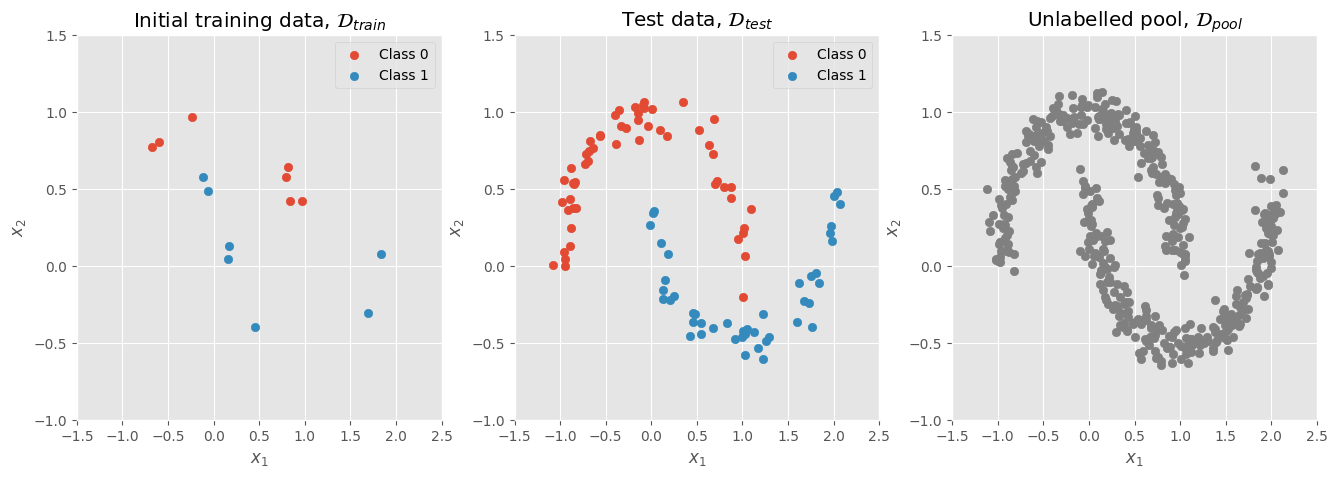

In [72]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 7
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_moons(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

In [76]:
# Define parameters
lr          = 1e-4
epochs      = 3000
val_step    = 1
seed        = 0

In [77]:
# Set device for model
model = SimpleLLLA(alpha=1., n_posterior_samples=5000)
model.to(device)

optimizer   = optim.Adam(model.parameters(), lr=lr)

train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed)

# "train" LLLA 
model.fit_LLLA(Xtrain, ytrain)

EPOCH 3000/3000: Train acc. = 1.0000 	 | Validation acc. = 0.9200 	 | Train loss = 0.0039 	 | Validation loss = 0.3180: 100%|██████████| 3000/3000 [00:15<00:00, 193.97it/s]

BEST EPOCH = 593


In [78]:
from src.methods.acquisition_functions import Entropy, BALD

In [79]:
def plot_example(acq_fun, next_query, P=150, zoom=None, auto_zoom=True):
    
    ### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)

    # Plot model uncertainty across grid
    axs[0], density_grid_output = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, P=P, auto_zoom=auto_zoom, zoom=zoom, ax=axs[0], fig=fig)
    axs[0].legend()

    decisions_bls = np.argmax(density_grid_output[2], axis=1).reshape((len(density_grid_output[0]), len(density_grid_output[1])))
    axs[1].pcolormesh(density_grid_output[0], density_grid_output[1], 1-decisions_bls, alpha=0.8, cmap=plt.cm.RdBu_r, shading='auto')        
    axs[1].set_title('Decision boundary')
    axs[1].set_xlabel('$x_1$')
    axs[1].grid(None)

    # Plot acquisition function across a grid
    axs[2] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, density_grid_output, P=P, auto_zoom=auto_zoom, zoom=zoom, ax=axs[2], fig=fig)
    axs[2].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
    axs[2].legend()
    return axs

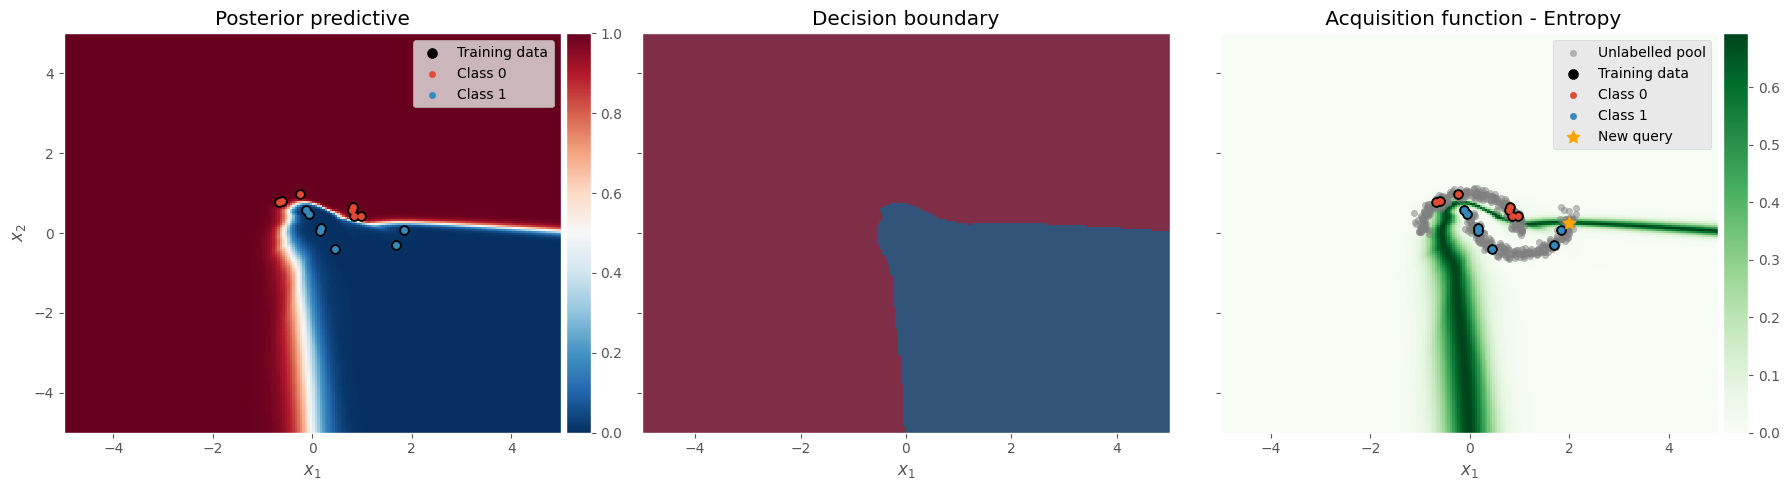

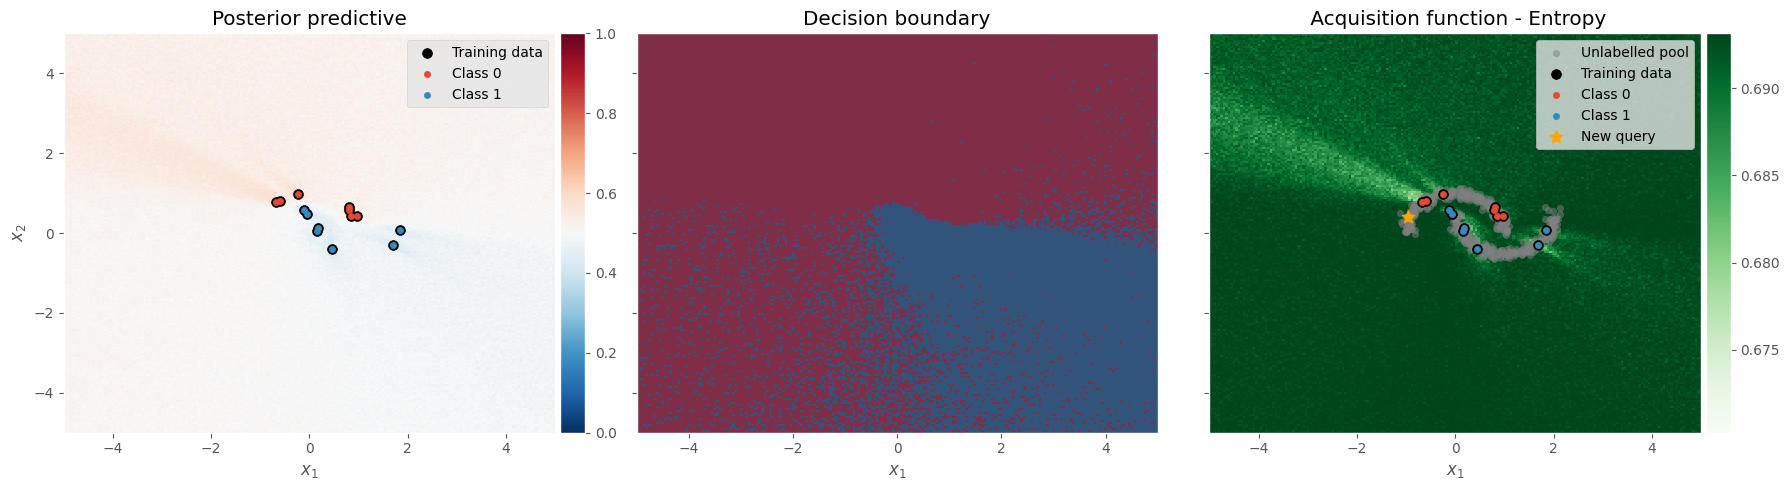

In [80]:
model.predict_proba = model.predict_MAP_proba
with torch.no_grad():
    # Define acquisition function
    acq_fun         = Entropy(query_n_points=None)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(acq_fun, next_query, P=200, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

model.predict_proba = model.predict_posterior_proba
with torch.no_grad():
    # Define acquisition function
    acq_fun         = Entropy(query_n_points=None)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(acq_fun, next_query, P=200, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

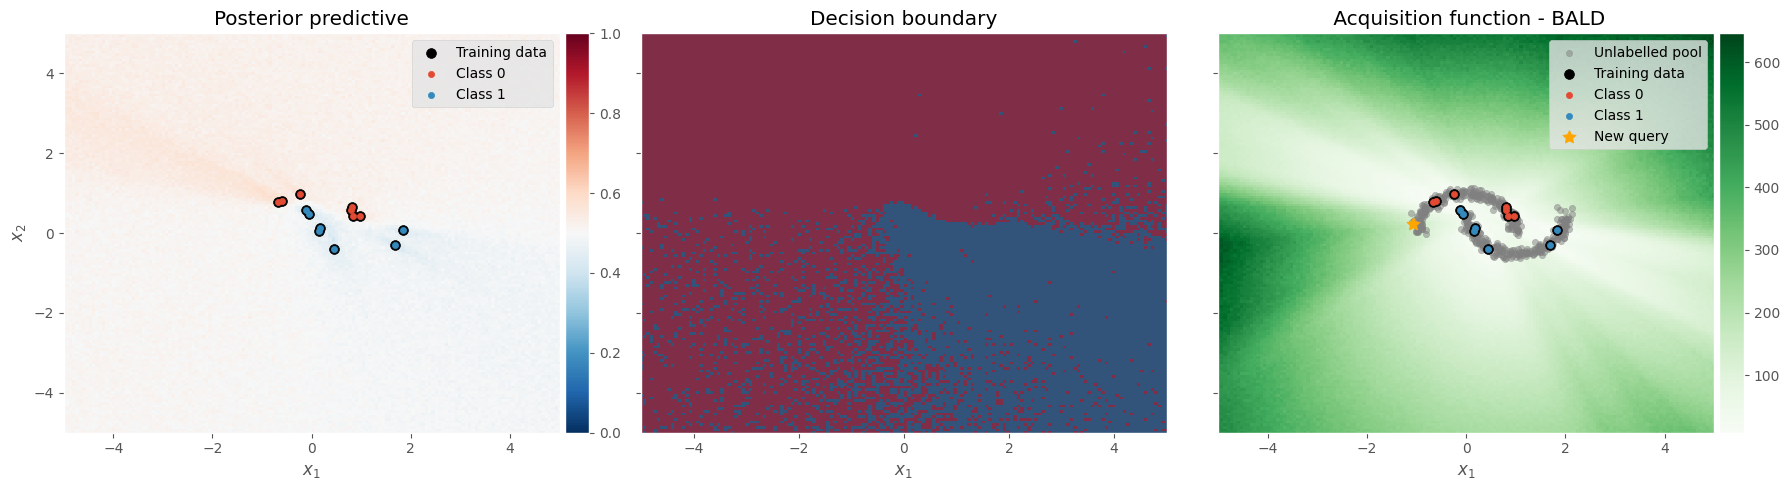

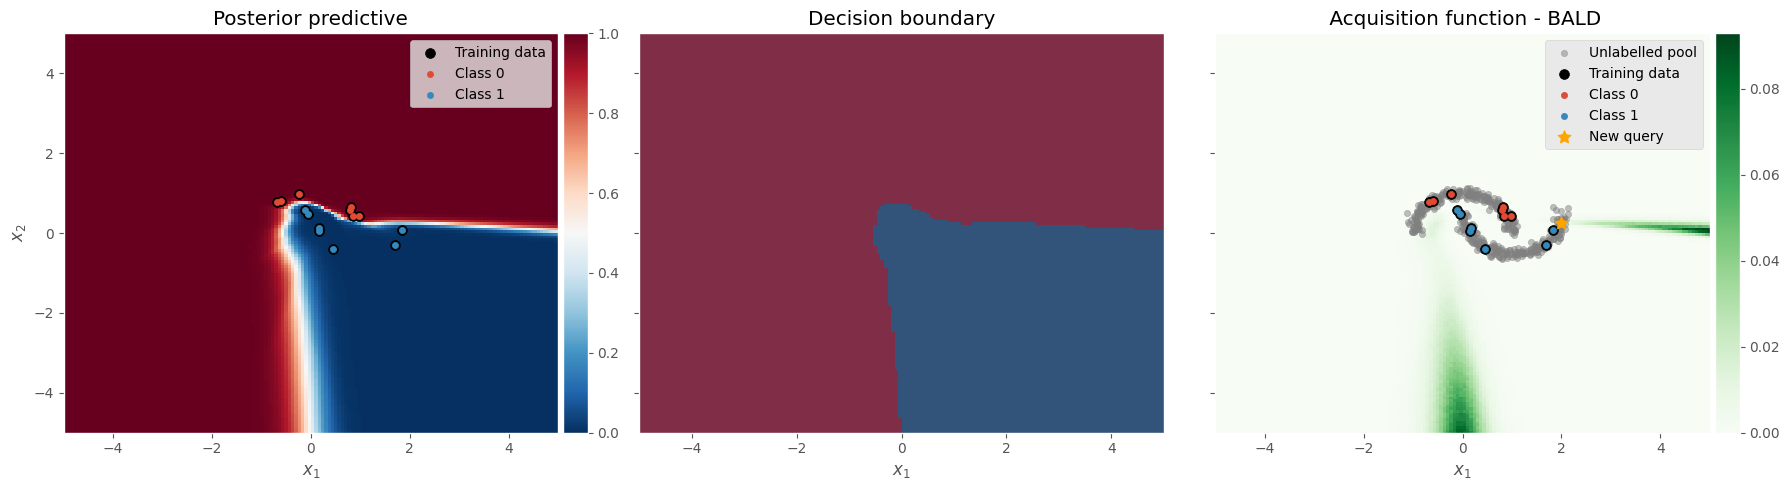

In [81]:
model.predict_proba     = model.predict_posterior_proba
model.variance_factor   = 1.
with torch.no_grad():
    # Define acquisition function
    acq_fun         = BALD(query_n_points=None, n_posterior_samples=2000)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(acq_fun, next_query, P=150, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

model.variance_factor   = 1e-6
with torch.no_grad():
    # Define acquisition function
    acq_fun         = BALD(query_n_points=None, n_posterior_samples=2000)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(acq_fun, next_query, P=150, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

In [14]:
# from src.methods.acquisition_functions import AcquisitionFunction
# from src.methods.target_input_distribution import TargetInputDistribution
# from typing import Tuple

# class MyEPIG(AcquisitionFunction):

#     def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
#         # Make target-input distribution accesible
#         self.target_input_distribution = target_input_distribution

#         # Set class-wide sampling parameters
#         self.n_posterior_samples    = n_posterior_samples
#         self.n_target_input_samples = n_target_input_samples
#         self.seed                   = seed

#         super().__init__(name='MyEPIG', query_n_points=query_n_points)

#     def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:

#         # Sample x* values from the target input distribution
#         Xstar                   = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        
#         # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
#         posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
#         posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)

#         pool_probs                  = torch.softmax(posterior_pool_samples, dim=0) #.mean(axis=1).T  
#         targ_probs                  = torch.softmax(posterior_target_samples, dim=0)# .mean(axis=1).T  

#         # Define constants
#         num_classes = pool_probs.shape[0]
#         K, M        = self.n_posterior_samples, self.n_target_input_samples

#         # Compute the joint term of the expression (summation on the numerator part of the fraction in the log)
#         joint_term          = torch.tensor(np.array([[((pool_probs[c, :, :] * targ_probs[c_star, :, j][:, None]).sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # Compute the independent term of the expression (summation on the denominator part of the fraction in the log)
#         independent_term    = torch.tensor(np.array([[(pool_probs[c, :, :].sum(axis=0) * targ_probs[c_star, :, j].sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # Compute log-term
#         log_term            = np.log(K * joint_term) - np.log(independent_term)
#         # Wrap it up and compute the final acquisition scores
#         acq_scores          = 1/M * log_term.sum(axis=(1, 0))

#         # Sort values
#         return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)
    
# model.variance_factor   = 1.
# model.predict_proba     = model.predict_posterior_proba

# for mu in [[-1.5, 1.5], [1.5, -1.5], [-1.5, -1.5], [1.5, 1.5], [-1.5, 0.0], [1.5, 0.0]]:
#     with torch.no_grad():
#         # Define acquisition function
#         target_input_dist = MultivariateGaussian(mu=mu, Sigma=np.eye(2) / 4)

#         # Define acquisition function
#         acq_fun = MyEPIG(
#             query_n_points=None, 
#             target_input_distribution=target_input_dist,
#             n_posterior_samples=100,
#             n_target_input_samples=5,
#         )

#         # Get acquisition function score and the items to query
#         _, query_idxs   = acq_fun(Xpool, model=model)
#         next_query      = Xpool[query_idxs[0]]

#         # Visualize
#         axs = plot_example(acq_fun, next_query, P=55, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
#         # Plot target input distribution on top
#         target_input_dist.plot_2D(ax=axs[2], zoom=([-5, 5], [-5, 5]))

#         plt.tight_layout()
#         plt.show()

\begin{align*}
    \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) &=  \sum_{i=0}^K \exp \log \biggl(p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i)\biggr) \\
    &= \sum_{i=0}^K \exp \biggl(\log p(y = c | x, \theta_i) + \log p(y^\ast = c | x^\ast_j, \theta_i)\biggr) \\
    &= \sum_{i=0}^K \exp \biggl(\log \frac{e^{z_c}}{\sum_{j \in \mathcal{Y}}{e^{z_j}}} + \log \frac{e^{z_c^\ast}}{\sum_{j \in \mathcal{Y^\ast}}{e^{z_j}}}\biggr) \\
    &= \sum_{i=0}^K \exp \biggl(z_c - \log \sum_{j \in \mathcal{Y}}{e^{z_j}} + z_c^\ast - \log \sum_{j \in \mathcal{Y^\ast}}{e^{z_j}} \biggr) \\
    &= \sum_{i=0}^K \exp \biggl(z_c + z_c^\ast - \log \sum_{j \in \mathcal{Y}}{e^{z_j}} - \log \sum_{j \in \mathcal{Y^\ast}}{e^{z_j}} \biggr) \\
\end{align*}

\begin{align*}
    \log \frac{\frac{\sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i)}{K}}{\frac{\sum_{i=0}^K p(y = c | x, \theta_i)}{K}  \frac{\sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i)}{K}} &= \log \frac{\sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i)}{K} - \log \biggl({\frac{\sum_{i=0}^K p(y = c | x, \theta_i)}{K}  \frac{\sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i)}{K}}\biggr) \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log K - \biggl( \log  \frac{\sum_{i=0}^K p(y = c | x, \theta_i)}{K} + \log \frac{\sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i)}{K} \biggr) \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log K - \biggl( \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log K + \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) - \log K \biggr) \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log K - \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) + 2 \log K \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) + \log K \\
    &= \log \sum_{i=0}^K \exp \biggl(z_c + z_c^\ast - \log \sum_{j \in \mathcal{Y}}{e^{z_j}} - \log \sum_{j \in \mathcal{Y^\ast}}{e^{z_j}} \biggr) - \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) + \log K \\
\end{align*}

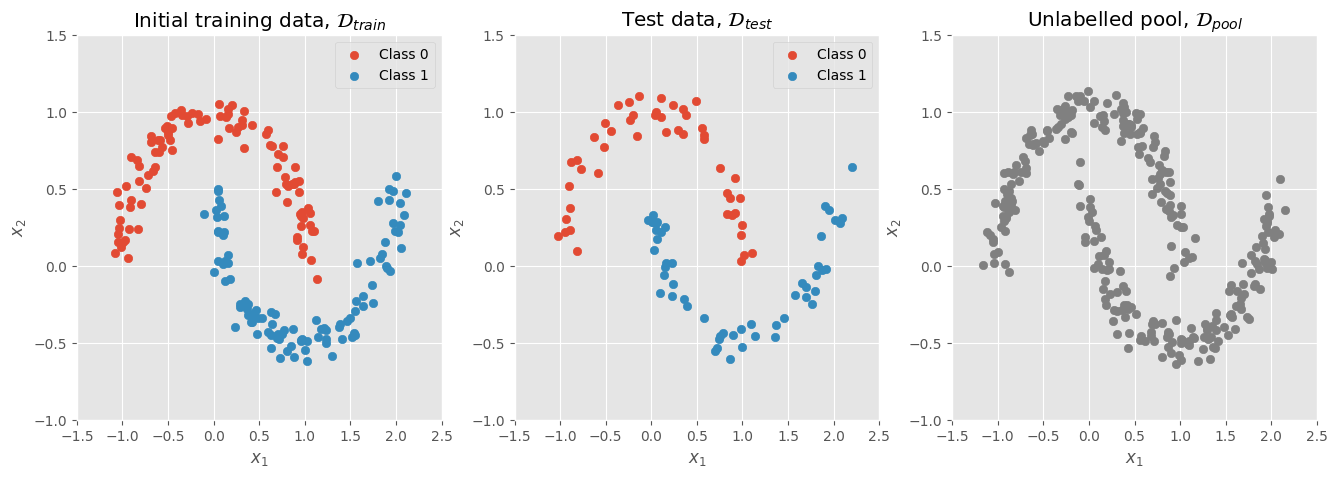

EPOCH 4000/4000: Train acc. = 1.0000 	 | Validation acc. = 1.0000 	 | Train loss = 0.0021 	 | Validation loss = 0.0021: 100%|██████████| 4000/4000 [00:31<00:00, 128.87it/s]


BEST EPOCH = 3999


In [98]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 100
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_moons(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

# Define parameters
lr          = 1e-4
epochs      = 4000
val_step    = 1
seed        = 0

# Set device for model
model = SimpleLLLA(alpha=1., n_posterior_samples=5000)
model.to(device)

optimizer   = optim.Adam(model.parameters(), lr=lr)

train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed)

# "train" LLLA 
model.fit_LLLA(Xtrain, ytrain)

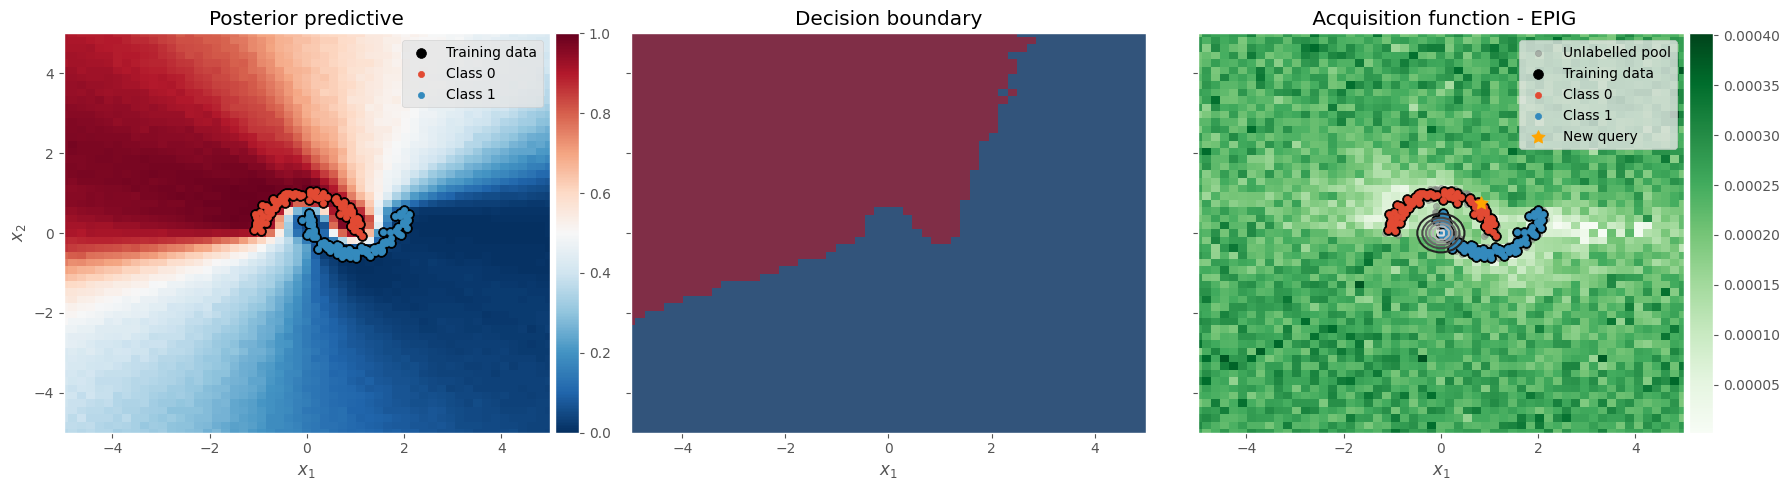

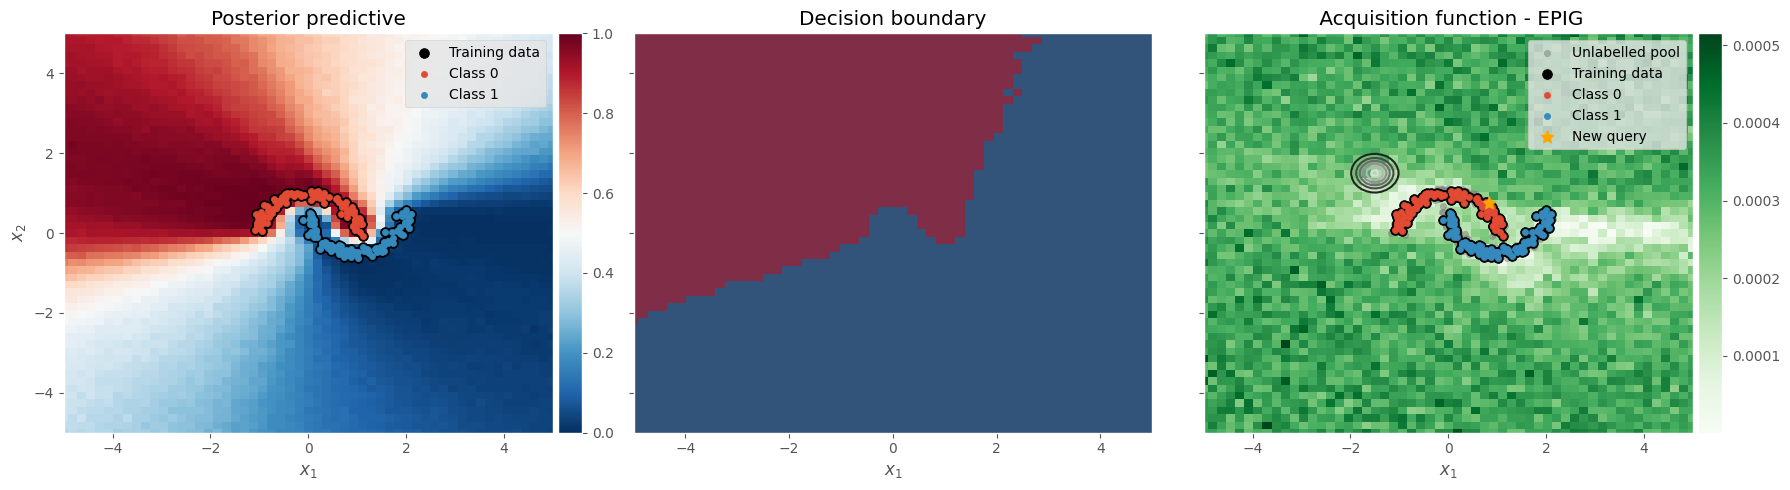

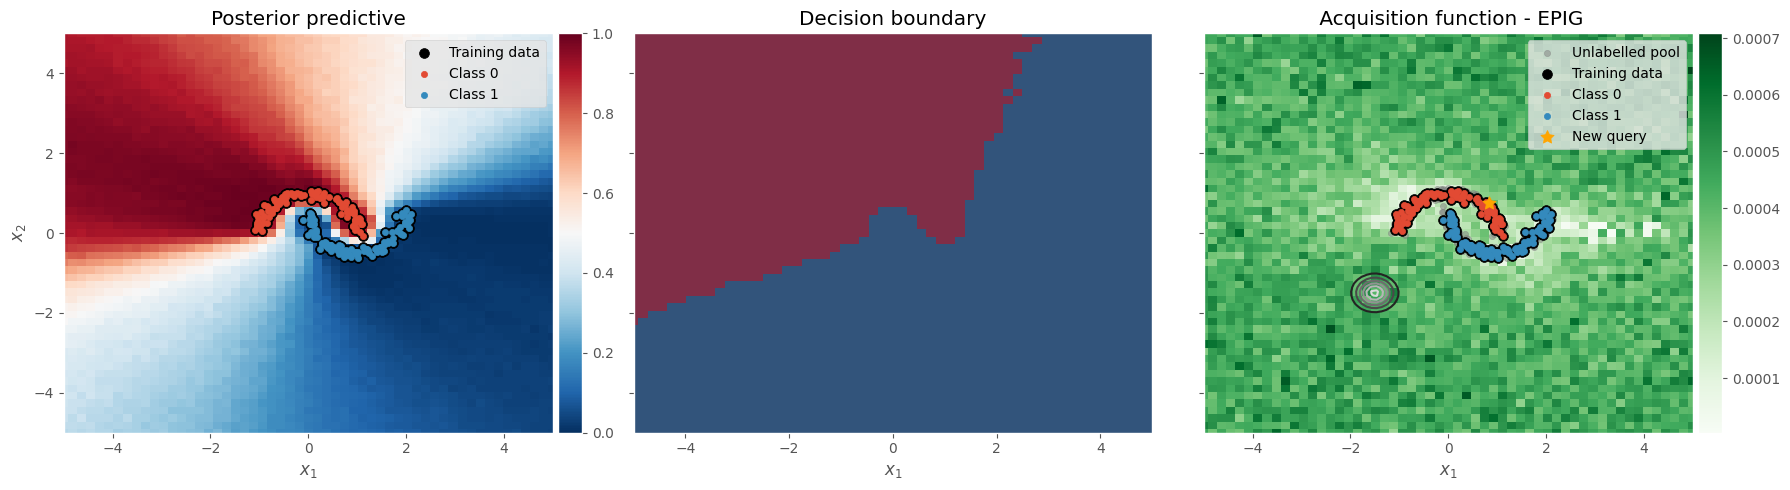

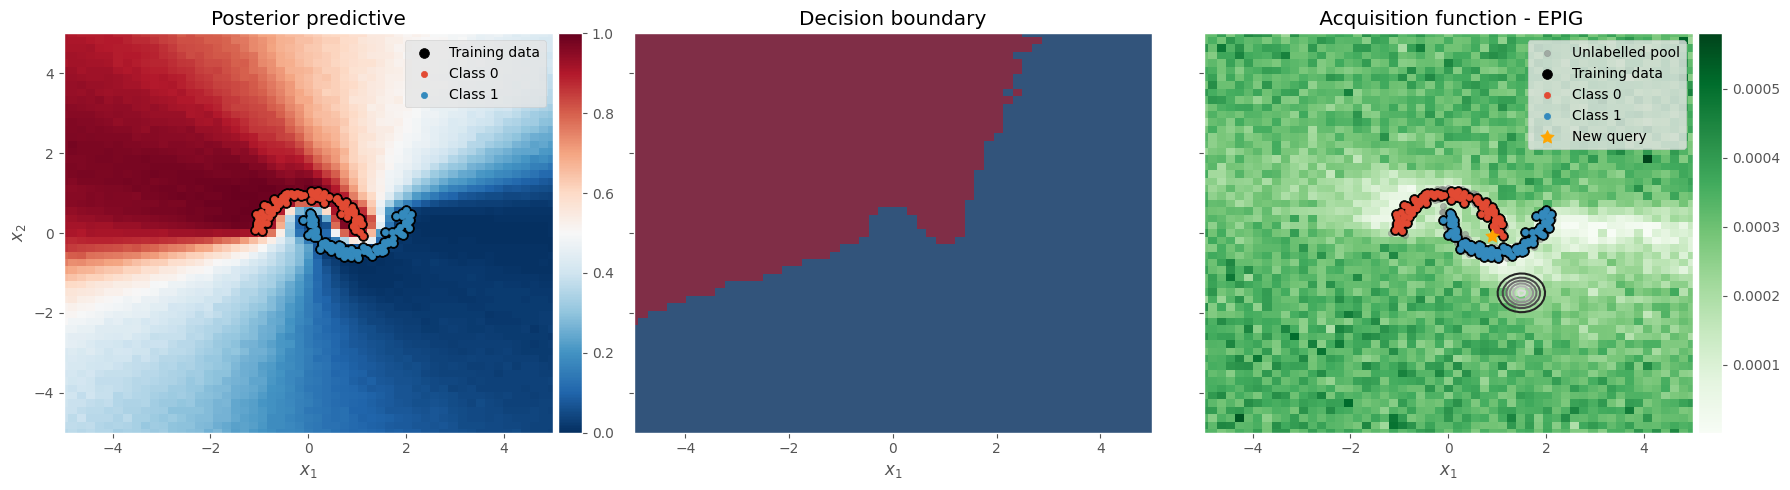

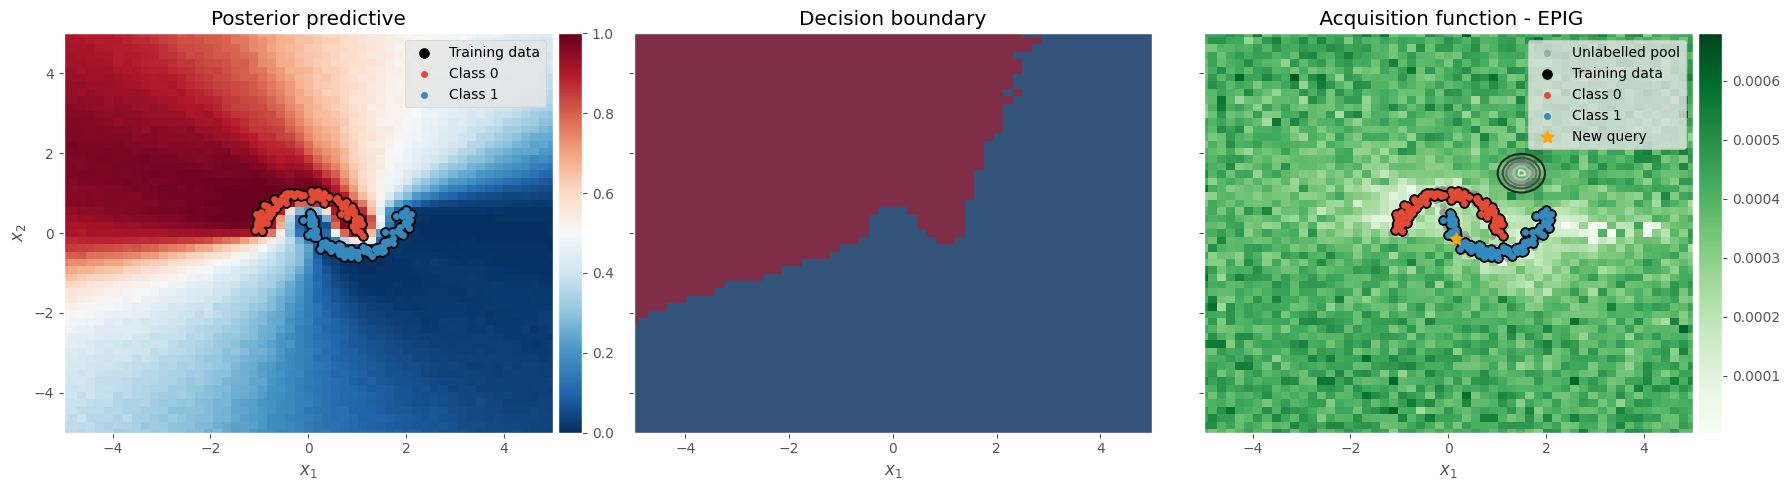

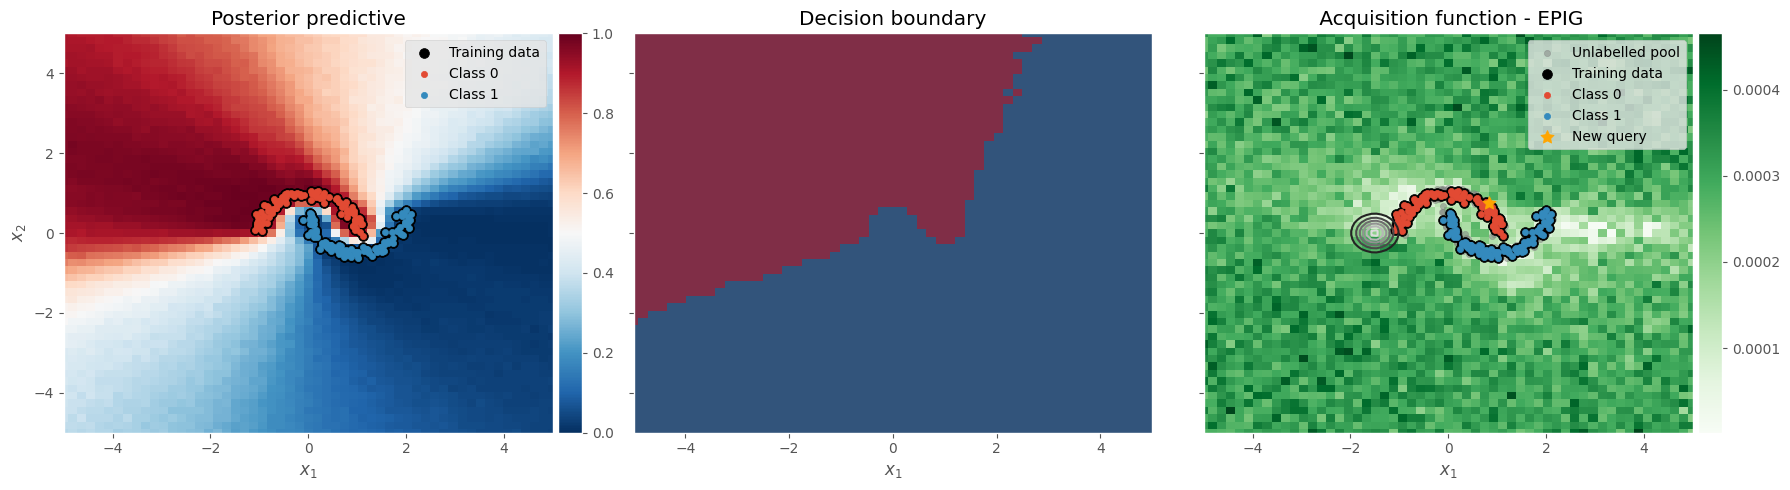

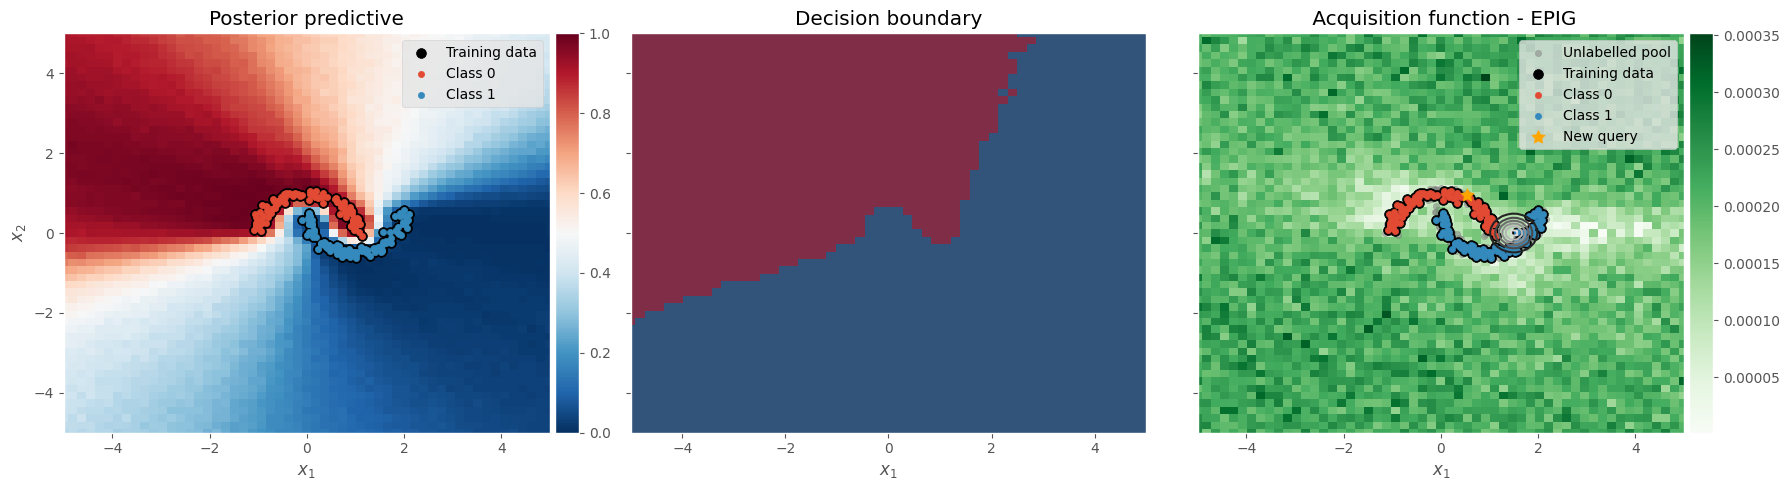

In [99]:
from src.methods.acquisition_functions import AcquisitionFunction
from src.methods.target_input_distribution import TargetInputDistribution
from typing import Tuple
import math

class EPIG(AcquisitionFunction):

    def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
        # Make target-input distribution accesible
        self.target_input_distribution = target_input_distribution

        # Set class-wide sampling parameters
        self.n_posterior_samples    = n_posterior_samples
        self.n_target_input_samples = n_target_input_samples
        self.seed                   = seed

        super().__init__(name='EPIG', query_n_points=query_n_points)

    def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        K, M        = self.n_posterior_samples, self.n_target_input_samples

        # Sample x* values from the target input distribution
        Xstar                       = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        self.Xstar                  = Xstar

        # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
        posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
        posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)

        logprobs_pool               = torch.log_softmax(posterior_pool_samples, dim=0)[:, None, :, :, None]
        logprobs_target             = torch.log_softmax(posterior_target_samples, dim=0)[None, :, :, None, :]

        logprobs_joint              = logprobs_pool + logprobs_target
        logprobs_joint              = torch.logsumexp(logprobs_joint, dim=2) - math.log(K)
        probs_joint                 = torch.exp(logprobs_joint)

        logprobs_independent        = (torch.logsumexp(logprobs_pool, dim=2) - math.log(K)) + (torch.logsumexp(logprobs_target, dim=2) - math.log(K))
        log_term                    = logprobs_joint - logprobs_independent

        acq_scores                  = (probs_joint * log_term).sum(dim=[0, 1])
        acq_scores                  = acq_scores.mean(dim=-1)
        assert torch.all((acq_scores + 1e-6 >= 0) & (acq_scores - 1e-6 <= math.inf)).item(), "Acquisition scores are not valid!"
        
        # Sort values
        return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)
    
model.variance_factor   = 1.
model.predict_proba     = model.predict_posterior_proba

for mu in [[0.0, 0.0], [-1.5, 1.5], [-1.5, -1.5], [1.5, -1.5], [1.5, 1.5], [-1.5, 0.0], [1.5, 0.0]]:
    with torch.no_grad():
        # Define acquisition function
        target_input_dist = MultivariateGaussian(mu=mu, Sigma=np.eye(2) / 4)

        # Define acquisition function
        acq_fun = EPIG(
            query_n_points=None, 
            target_input_distribution=target_input_dist,
            n_posterior_samples=1000,
            n_target_input_samples=100,
            seed=0
        )

        # Get acquisition function score and the items to query
        _, query_idxs   = acq_fun(Xpool, model=model)
        next_query      = Xpool[query_idxs[0]]

        # Visualize
        axs = plot_example(acq_fun, next_query, P=55, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
        # axs[2].scatter(acq_fun.Xstar[:, 0], acq_fun.Xstar[:, 1], marker='s', s=50, color='k')
        # Plot target input distribution on top
        target_input_dist.plot_2D(ax=axs[2], zoom=([-5, 5], [-5, 5]))

        plt.tight_layout()
        plt.show()

### BLOBS

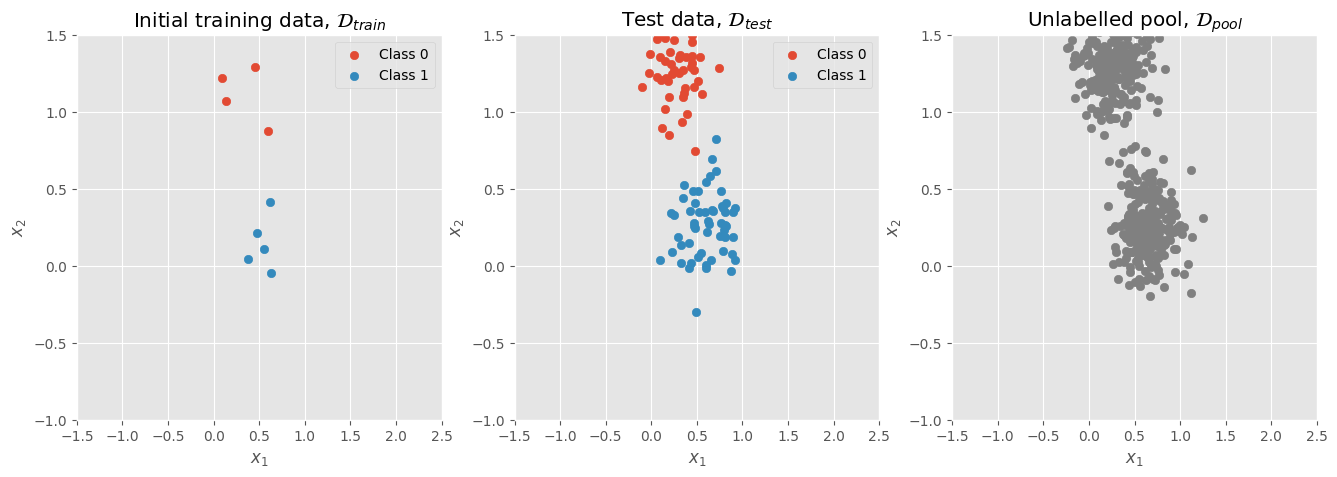

EPOCH 2000/2000: Train acc. = 1.0000 	 | Validation acc. = 0.9800 	 | Train loss = 0.0114 	 | Validation loss = 0.0901: 100%|██████████| 2000/2000 [00:17<00:00, 113.19it/s]


BEST EPOCH = 1999


In [100]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 5
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_multiclass(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool, num_classes=num_classes, noise=0.2)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

# Define parameters
lr          = 1e-4
epochs      = 2000
val_step    = 1
seed        = 0

# Set device for model
model = SimpleLLLA(alpha=1., n_posterior_samples=5000)
model.to(device)

optimizer   = optim.Adam(model.parameters(), lr=lr)

train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed)

# "train" LLLA 
model.fit_LLLA(Xtrain, ytrain)

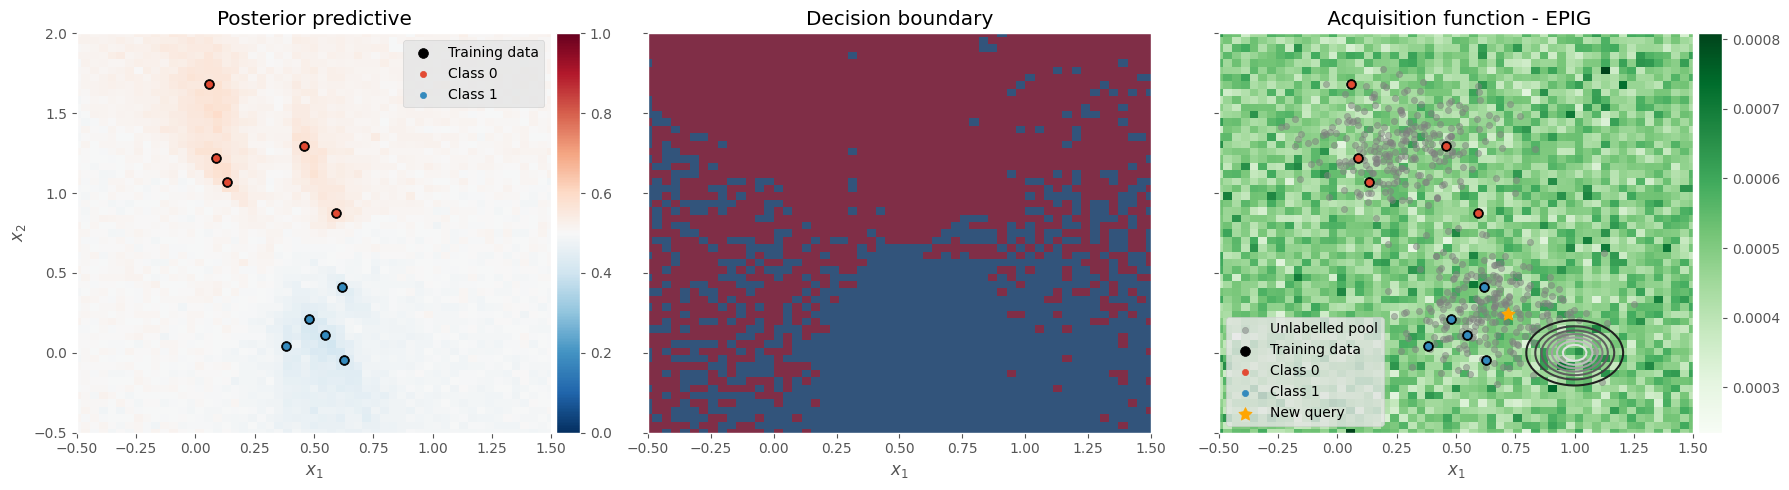

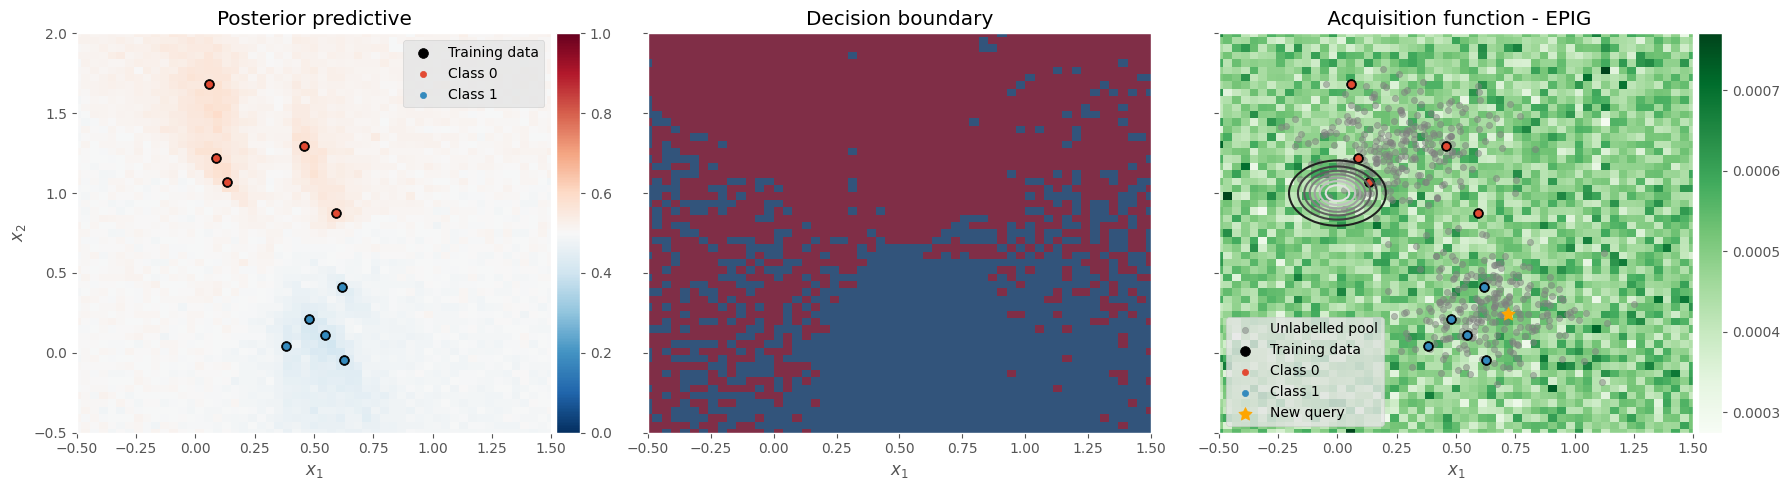

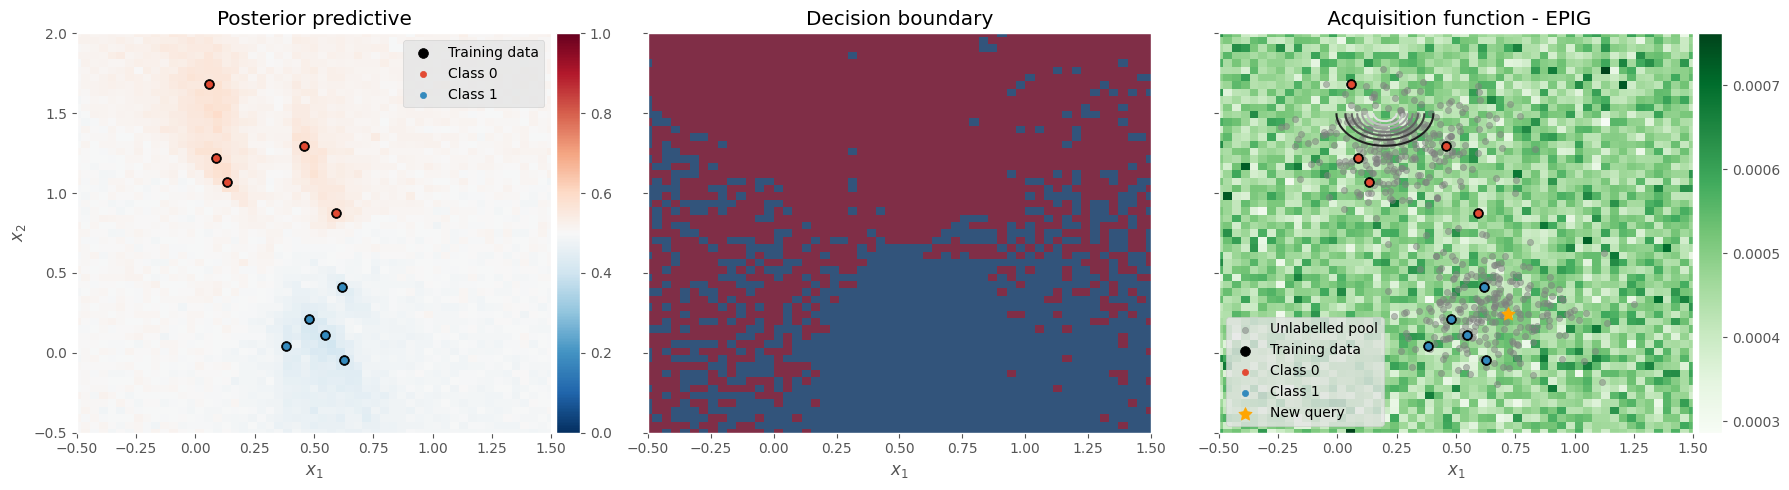

In [101]:
from src.methods.acquisition_functions import AcquisitionFunction
from src.methods.target_input_distribution import TargetInputDistribution
from typing import Tuple
import math

class EPIG(AcquisitionFunction):

    def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
        # Make target-input distribution accesible
        self.target_input_distribution = target_input_distribution

        # Set class-wide sampling parameters
        self.n_posterior_samples    = n_posterior_samples
        self.n_target_input_samples = n_target_input_samples
        self.seed                   = seed

        super().__init__(name='EPIG', query_n_points=query_n_points)

    def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        K, M        = self.n_posterior_samples, self.n_target_input_samples

        # Sample x* values from the target input distribution
        Xstar                       = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        self.Xstar                  = Xstar

        # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
        posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
        posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)

        logprobs_pool               = torch.log_softmax(posterior_pool_samples, dim=0)[:, None, :, :, None]
        logprobs_target             = torch.log_softmax(posterior_target_samples, dim=0)[None, :, :, None, :]

        logprobs_joint              = logprobs_pool + logprobs_target
        logprobs_joint              = torch.logsumexp(logprobs_joint, dim=2) - math.log(K)
        probs_joint                 = torch.exp(logprobs_joint)

        logprobs_independent        = (torch.logsumexp(logprobs_pool, dim=2) - math.log(K)) + (torch.logsumexp(logprobs_target, dim=2) - math.log(K))
        log_term                    = logprobs_joint - logprobs_independent

        acq_scores                  = (probs_joint * log_term).sum(dim=[0, 1])
        acq_scores                  = acq_scores.mean(dim=-1)
        assert torch.all((acq_scores + 1e-6 >= 0) & (acq_scores - 1e-6 <= math.inf)).item(), "Acquisition scores are not valid!"
        
        # Sort values
        return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)
    
model.variance_factor   = 1.
model.predict_proba     = model.predict_posterior_proba

for mu in [[1.0, 0.0], [0.0, 1.0], [0.2, 1.5]]:
    with torch.no_grad():
        # Define acquisition function
        target_input_dist = MultivariateGaussian(mu=mu, Sigma=np.eye(2) / 10)

        # Define acquisition function
        acq_fun = EPIG(
            query_n_points=None, 
            target_input_distribution=target_input_dist,
            n_posterior_samples=1000,
            n_target_input_samples=100,
            seed=0
        )

        # Get acquisition function score and the items to query
        _, query_idxs   = acq_fun(Xpool, model=model)
        next_query      = Xpool[query_idxs[0]]

        # Visualize
        axs = plot_example(acq_fun, next_query, P=55, auto_zoom=False, zoom=([-0.5, 1.5], [-0.5, 2]))
        # axs[2].scatter(acq_fun.Xstar[:, 0], acq_fun.Xstar[:, 1], marker='s', s=50, color='k')
        # Plot target input distribution on top
        target_input_dist.plot_2D(ax=axs[2], zoom=([-0.5, 1.5], [-0.5, 2]))

        plt.tight_layout()
        plt.show()

In [9]:
# from src.methods.acquisition_functions import AcquisitionFunction
# from src.methods.target_input_distribution import TargetInputDistribution
# from typing import Tuple

# class GeneralEPIG(AcquisitionFunction):

#     def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
#         # Make target-input distribution accesible
#         self.target_input_distribution = target_input_distribution

#         # Set class-wide sampling parameters
#         self.n_posterior_samples    = n_posterior_samples
#         self.n_target_input_samples = n_target_input_samples
#         self.seed                   = seed

#         super().__init__(name='GeneralEPIG', query_n_points=query_n_points)

#     def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:

#         # Sample x* values from the target input distribution
#         Xstar                   = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        
#         # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
#         # _, probs_pool  = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
#         # _, probs_targ  = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)
#         posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed).permute(1, 2, 0)
#         posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed).permute(1, 2, 0)

#         # pool_probs                  = torch.softmax(posterior_pool_samples, dim=0) #.mean(axis=1).T  
#         # targ_probs                  = torch.softmax(posterior_target_samples, dim=0)# .mean(axis=1).T  
        
#         # Define constants
#         num_classes = posterior_pool_samples.shape[2]
#         K, M        = self.n_posterior_samples, self.n_target_input_samples

#         log_probs_pool      = (posterior_pool_samples - torch.logsumexp(posterior_pool_samples, dim=2, keepdim=True))[:, :, None, :, None]
#         log_probs_target    = (posterior_target_samples - torch.logsumexp(posterior_target_samples, dim=2, keepdim=True))[:, None, :, None, :]
#         log_probs_joint     = log_probs_pool + log_probs_target
#         probs_joint         = torch.exp(log_probs_joint)

#         import math
#         log_numerator   = math.log(K) + torch.logsumexp(log_probs_joint, dim=0, keepdim=True)
#         log_denominator = torch.logsumexp(log_probs_pool, dim=0, keepdim=True) + torch.logsumexp(log_probs_target, dim=0, keepdim=True)
#         log_fraction    = log_numerator - log_denominator

#         acq_scores = (probs_joint.mean(dim=0, keepdim=True)  * log_fraction).sum(dim=[4, 3]).mean(dim=2).flatten()
        
#         # # Compute the joint term of the expression (summation on the numerator part of the fraction in the log)
#         # joint_term          = torch.tensor(np.array([[((pool_probs[c, :, :] * targ_probs[c_star, :, j][:, None]).sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # # Compute the independent term of the expression (summation on the denominator part of the fraction in the log)
#         # independent_term    = torch.tensor(np.array([[(pool_probs[c, :, :].sum(axis=0) * targ_probs[c_star, :, j].sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # # Compute log-term
#         # log_term            = np.log(K * joint_term) - np.log(independent_term)
#         # # Wrap it up and compute the final acquisition scores
#         # acq_scores          = 1/M * log_term.sum(axis=(1, 0))

#         # Sort values
#         return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)

In [102]:

# model.variance_factor   = 1.
# model.predict_proba     = model.predict_posterior_proba
# with torch.no_grad():
#     # Define acquisition function
#     target_input_dist = MultivariateGaussian(mu=[0, 0], Sigma=np.eye(2) / 4)

#     # Define acquisition function
#     acq_fun = GeneralEPIG(
#         query_n_points=None, 
#         target_input_distribution=target_input_dist,
#         n_posterior_samples=1000,
#         n_target_input_samples=100,
#     )

#     # Get acquisition function score and the items to query
#     _, query_idxs   = acq_fun(Xpool, model=model)
#     next_query      = Xpool[query_idxs[0]]

#     # Visualize
#     axs = plot_example(acq_fun, next_query, P=25, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
#     # Plot target input distribution on top
#     target_input_dist.plot_2D(ax=axs[2], zoom=([-5, 5], [-5, 5]))

#     plt.tight_layout()
#     plt.show()